In [1]:
import os
import sys
import time
import copy
import random
import logging
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict, defaultdict
from scipy.misc import imread
from sklearn.model_selection import RepeatedKFold
from skimage.transform import resize
from sklearn.metrics import f1_score
import pathlib
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split


import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.models import resnet50


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
print ("1. Loading data & Converting data")
print ("----------------------------------------")
path="/media/haidro/harddisk1t/kaggle/protein_atlas"
print('Data files: ')
for file in os.listdir(path):
    print(file) 
print ("----------------------------------------")
train_label = pd.read_csv(path+"/train.csv")
print("There is %s samples in traininig set."%train_label.shape[0])
test_label = pd.read_csv(path+"/sample_submission.csv")
print("There is %s samples in testing set."%test_label.shape[0])
print ("----------------------------------------")
print ("There are in total 28 different labels present in the dataset, each image has various possible labels.")
# train_label
train_label.head()

1. Loading data & Converting data
----------------------------------------
Data files: 
test
.ipynb_checkpoints
sample_submission.csv
train
train.csv
----------------------------------------
There is 31072 samples in traininig set.
There is 11702 samples in testing set.
----------------------------------------
There are in total 28 different labels present in the dataset, each image has various possible labels.


,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


#### convert the Target into one-of_K scheme

In [4]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}
reverse_train_label = dict((v,k) for k,v in label_names.items())

def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row
for key in label_names.keys():
    train_label[label_names[key]] = 0
train_label = train_label.apply(fill_targets, axis=1)
train_label.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]",1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5],0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1],0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18],0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


###### Show the highest frequent labels in the dataset

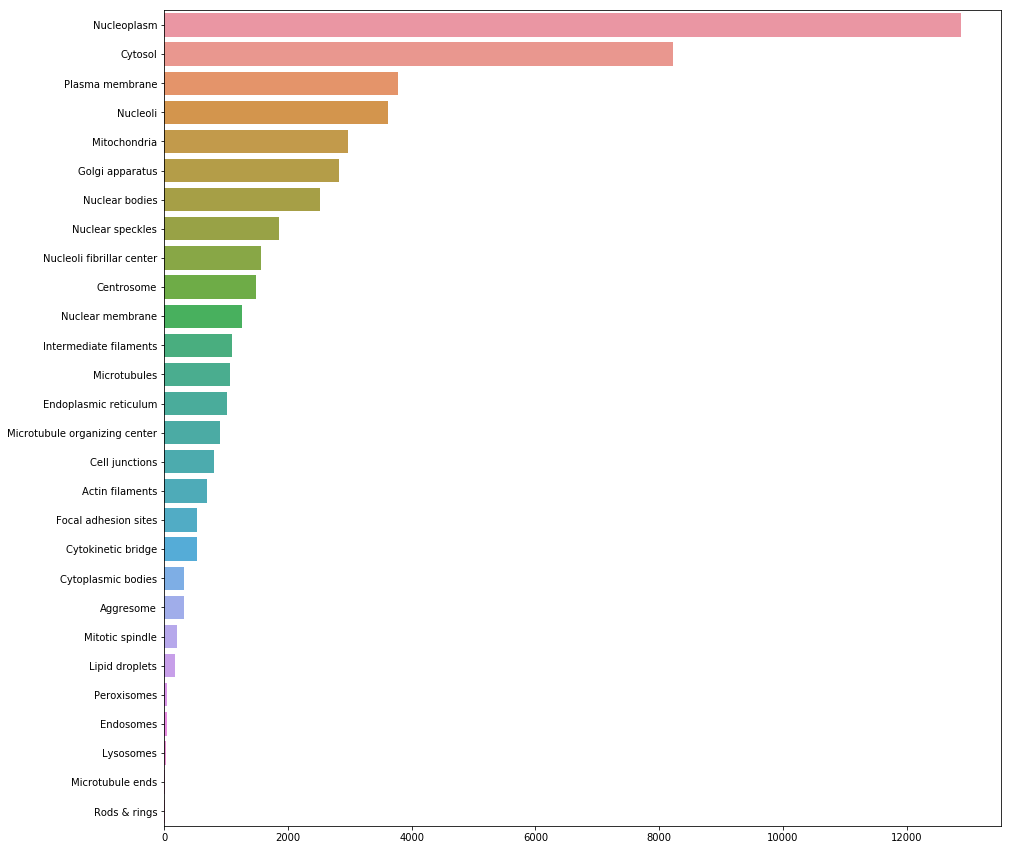

In [5]:
target_counts = train_label.drop(["Id", "Target"],axis=1).sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(y=target_counts.index.values, x=target_counts.values, order=target_counts.index)

##### Build an batch data loader for Pytorch
* Data muct be wrapped on a Dataset parent class where the methods $ \_getitem\_ $ and $ \_len\_ $ must be overried. Note that at this point the data is loaded on memory. Pytorch will only load what is needed to the memory by passing to the dataloader.

In [12]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
import torch
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import pathlib
import torchvision.transforms as transforms
import torch
import PIL
from sklearn.model_selection import train_test_split

import sys
import pandas as pd
# from neptune import Context
from sklearn.metrics import f1_score
import torch.nn as nn
import torchvision.transforms as transforms
from torch import optim, save
from torch.utils.data import DataLoader
from torchvision.models import resnet50


from ignite.engine.engine import Events
from ignite.engine import create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import CategoricalAccuracy, Recall, Precision
from ignite.metrics import Loss
import numpy as np
RANDOM_SEED = 666

LABEL_MAP = {
0: "Nucleoplasm" ,
1: "Nuclear membrane"   ,
2: "Nucleoli"   ,
3: "Nucleoli fibrillar center",   
4: "Nuclear speckles"   ,
5: "Nuclear bodies"   ,
6: "Endoplasmic reticulum"   ,
7: "Golgi apparatus"  ,
8: "Peroxisomes"   ,
9:  "Endosomes"   ,
10: "Lysosomes"   ,
11: "Intermediate filaments"  , 
12: "Actin filaments"   ,
13: "Focal adhesion sites"  ,
14: "Microtubules"   ,
15: "Microtubule ends"   ,
16: "Cytokinetic bridge"   ,
17: "Mitotic spindle"  ,
18: "Microtubule organizing center",  
19: "Centrosome",
20: "Lipid droplets"   ,
21: "Plasma membrane"  ,
22: "Cell junctions"   ,
23: "Mitochondria"   ,
24: "Aggresome"   ,
25: "Cytosol" ,
26: "Cytoplasmic bodies",
27: "Rods & rings"}



class MultiBandMultiLabelDataset(Dataset):
    BANDS_NAMES = ['_red.png','_green.png','_blue.png','_yellow.png']
    
    def __len__(self):
        return len(self.images_df)
    
    def __init__(self, images_df, 
                 base_path, 
                 image_transform, 
                 augmentator=None,
                 train_mode=True    
                ):
        if not isinstance(base_path, pathlib.Path):
            base_path = pathlib.Path(base_path)
            
        self.images_df = images_df.copy()
        self.image_transform = image_transform
        self.augmentator = augmentator
        self.images_df.Id = self.images_df.Id.apply(lambda x: base_path / x)
        self.mlb = MultiLabelBinarizer(classes=list(LABEL_MAP.keys()))
        self.train_mode = train_mode

                                      
        
    def __getitem__(self, index):
        y = None
        X = self._load_multiband_image(index)
        if self.train_mode:
            y = self._load_multilabel_target(index)
        
        # augmentator can be for instance imgaug augmentation object
        if self.augmentator is not None:
            X = self.augmentator(X)
            
        X = self.image_transform(X)
            
        return X, y 
        
    def _load_multiband_image(self, index):
        row = self.images_df.iloc[index]
        image_bands = []
        for band_name in self.BANDS_NAMES:
            p = str(row.Id.absolute()) + band_name
            pil_channel = PIL.Image.open(p)
            image_bands.append(pil_channel)
            
        # lets pretend its a RBGA image to support 4 channels
        band4image = PIL.Image.merge('RGBA', bands=image_bands)
        return band4image
    
    
    def _load_multilabel_target(self, index):
        return list(map(int, self.images_df.iloc[index].Target.split(' ')))
    
        
    def collate_func(self, batch):
        labels = None
        images = [x[0] for x in batch]
        
        if self.train_mode:
            labels = [x[1] for x in batch]
            labels_one_hot  = self.mlb.fit_transform(labels)
            labels = torch.FloatTensor(labels_one_hot)
            
        
        return torch.stack(images)[:,:4,:,:], labels

def get_model(n_classes, image_channels=4):
    model = resnet50(pretrained=True)
    for p in model.parameters():
        p.requires_grad = True
    inft = model.fc.in_features
    model.fc = nn.Linear(in_features=inft, out_features=n_classes)
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    model.conv1 = nn.Conv2d(image_channels,64, kernel_size=7, stride=2, padding=3,
                               bias=False)
    
    return model  


def train(trainer, train_loader, test_loader, checkpoint_path='bestmodel_{}_{}.torch', epochs=1):
    @trainer.on(Events.ITERATION_COMPLETED)
    def log_training_loss(engine):
        iter = (engine.state.iteration - 1) % len(train_loader) + 1
#         ctx.channel_send('loss', engine.state.output)
        if iter % 10 == 0:
            print("Epoch[{}] Iteration[{}/{}] Loss: {:.2f}"
                  "".format(engine.state.epoch, iter, len(train_loader), engine.state.output))

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(engine):
        evaluator.run(test_loader)
        metrics = evaluator.state.metrics
        avg_nll = metrics['loss']
        print("Training Results - Epoch: {}  Avg loss: {:.2f}"
              .format(engine.state.epoch, avg_nll))
        save(model, checkpoint_path.format(engine.state.epoch, avg_nll))
    trainer.run(train_loader, max_epochs=epochs)
    
    return model 
    

# Eval
def evaluate(model, test_loader, threshold=0.3):
    all_preds = []
    true = []
    model.eval()
    for b in test_loader:
        X, y = b
        if torch.cuda.is_available():
            X, y = X.cuda(), y.cuda()
        pred = model(X)
        all_preds.append(pred.sigmoid().cpu().data.numpy())
        true.append(y.cpu().data.numpy())
        
        
    P = np.concatenate(all_preds)
    R = np.concatenate(true)
    
    f1 = f1_score(P>threshold, R, average='macro')
    print(f1)
    return f1
    

## Submission
def predict_submission(model, submission_load):
    all_preds = []
    model.eval()
    for i, b in enumerate(submission_load):
        if i % 100: print('processing batch {}/{}'.format(i, len(submission_load)))
        X, _ = b
        if torch.cuda.is_available():
            X = X.cuda()
        pred = model(X)
        all_preds.append(pred.sigmoid().cpu().data.numpy())
    return np.concatenate(all_preds)
        
         
def make_submission_file(sample_submission_df, predictions):
    submissions = []
    for row in predictions:
        subrow = ' '.join(list([str(i) for i in np.nonzero(row)[0]]))
        submissions.append(subrow)
    
    sample_submission_df['Predicted'] = submissions
    sample_submission_df.to_csv('submission.csv', index=None)
    
    return sample_submission_df

    
PATH_TO_IMAGES = path+'/train/'
PATH_TO_TEST_IMAGES = path+'/test/'
PATH_TO_META = path+'/train.csv'
SAMPLE_SUBMI = path+'/sample_submission.csv'
# Prepare dataframe files

SEED = 66
DEV_MODE = True
    
df = pd.read_csv(PATH_TO_META)
df_train, df_test  = train_test_split(df, test_size=0.3, random_state=SEED)
df_submission = pd.read_csv(SAMPLE_SUBMI)

if DEV_MODE:
    df_train = df_train[:2000]
    df_test = df_test[:1000]
    df_submission = df_submission

image_transform = transforms.Compose([
            transforms.Resize(64),
            transforms.ToTensor(),
    
        ])

 
# Prepare datasets and loaders
   
gtrain = MultiBandMultiLabelDataset(df_train, base_path=PATH_TO_IMAGES, image_transform=image_transform)
gtest = MultiBandMultiLabelDataset(df_test, base_path=PATH_TO_IMAGES, image_transform=image_transform)
gsub = MultiBandMultiLabelDataset(df_submission, base_path=PATH_TO_TEST_IMAGES, train_mode=False, image_transform=image_transform)

train_load = DataLoader(gtrain, collate_fn=gtrain.collate_func, batch_size=16, num_workers=6)
test_load = DataLoader(gtest, collate_fn=gtest.collate_func, batch_size=16, num_workers=6)
submission_load = DataLoader(gsub, collate_fn=gsub.collate_func, batch_size=16, num_workers=6)


# Prepare model 
model = get_model(28,4)
device='cuda'
criterion = nn.MultiLabelSoftMarginLoss()
if torch.cuda.is_available():
    criterion = criterion.cuda()
evaluator = create_supervised_evaluator(model,
                                            device=device,
                                            metrics={'loss': Loss(criterion)
                                                    })
optimizer = optim.Adam(filter(lambda p: p.requires_grad,model.parameters()), lr=0.00005)
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

In [6]:
# train the model
model = train(trainer, train_load, test_load, epochs=12)

Epoch[1] Iteration[10/125] Loss: 0.52
Epoch[1] Iteration[20/125] Loss: 0.40
Epoch[1] Iteration[30/125] Loss: 0.31
Epoch[1] Iteration[40/125] Loss: 0.29
Epoch[1] Iteration[50/125] Loss: 0.23
Epoch[1] Iteration[60/125] Loss: 0.22
Epoch[1] Iteration[70/125] Loss: 0.20
Epoch[1] Iteration[80/125] Loss: 0.19
Epoch[1] Iteration[90/125] Loss: 0.20
Epoch[1] Iteration[100/125] Loss: 0.17
Epoch[1] Iteration[110/125] Loss: 0.18
Epoch[1] Iteration[120/125] Loss: 0.17
Training Results - Epoch: 1  Avg loss: 0.18
Epoch[2] Iteration[10/125] Loss: 0.16
Epoch[2] Iteration[20/125] Loss: 0.16
Epoch[2] Iteration[30/125] Loss: 0.15
Epoch[2] Iteration[40/125] Loss: 0.16
Epoch[2] Iteration[50/125] Loss: 0.13
Epoch[2] Iteration[60/125] Loss: 0.15
Epoch[2] Iteration[70/125] Loss: 0.13
Epoch[2] Iteration[80/125] Loss: 0.12
Epoch[2] Iteration[90/125] Loss: 0.14
Epoch[2] Iteration[100/125] Loss: 0.11
Epoch[2] Iteration[110/125] Loss: 0.14
Epoch[2] Iteration[120/125] Loss: 0.12
Training Results - Epoch: 2  Avg loss:

Process Process-148:
Process Process-149:
Process Process-146:
Process Process-147:
Process Process-150:
Process Process-145:
Traceback (most recent call last):
  File "/home/haidro/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/haidro/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/haidro/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/haidro/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-5-24a39e466fce>", line 90, in __getitem__
    X = self._load_multiband_image(index)
  File "<ipython-input-5-24a39e466fce>", line 107, in _load_multiband_image
    pil_channel = PIL.Image.open(p)
  File "/home

Traceback (most recent call last):
  File "/home/haidro/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-451241270570>", line 2, in <module>
    model = train(trainer, train_load, test_load, epochs=30)
  File "<ipython-input-5-24a39e466fce>", line 161, in train
    trainer.run(train_loader, max_epochs=epochs)
  File "/home/haidro/anaconda3/lib/python3.6/site-packages/ignite/engine/engine.py", line 223, in run
    self._handle_exception(e)
  File "/home/haidro/anaconda3/lib/python3.6/site-packages/ignite/engine/engine.py", line 188, in _handle_exception
    raise e
  File "/home/haidro/anaconda3/lib/python3.6/site-packages/ignite/engine/engine.py", line 210, in run
    hours, mins, secs = self._run_once_on_dataset()
  File "/home/haidro/anaconda3/lib/python3.6/site-packages/ignite/engine/engine.py", line 177, in _run_once_on_dataset
    self._handle_exception(e)


KeyboardInterrupt: 

In [13]:
# evaluate on testing data and calculate F1-macro
res = evaluate(model, test_load, threshold=0.3)
print(res)

0.09679798935117859
0.09679798935117859


In [ ]:
submission_predictions =predict_submission(model, submission_load)

In [ ]:
# prepare the submission file and 
THRESHOLD = 0.2
p = submission_predictions>THRESHOLD

submission_file = make_submission_file(sample_submission_df=df_submission,
                     predictions=p)

In [ ]:
submission_file.head()

In [ ]:
submission_file.shape

### Pytorch  tutorial


In [18]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = path+''
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

KeyError: 'train/'